# Clustering/Segmenting popular touristic cities around the world

This notebook corresponds to the Final Capstone Project of the IBM Applied Data Science course, available in Coursera.

The main goal of this project is to perform a segmentation with clustering models, of the 100 most visited cities in the world, by analyzing their most popular venues and places of all kinds, including museums, cultural places, restaurants, and so on.

In this notebook we just perform the Data collection, Analysis and Clustering, explaining the processes needed and the steps followed, so review the final report in the GitHub repository to obtain more information about the problem, planning and documentation of this project.

### Contents:

- Section 1: Getting the data of the 100 most visited cities in the world.
- Section 2: Explorating and Visualizing the cities data.
- Section 3: Getting the data of the most popular venues for each city.
- Section 4: Preprocessing the venues data.
- Section 5: Clustering the cities.
- Section 6: Analyzing the resultant clusters.
- Final Thoughts

So let's get started. First we import the main packages:

In [1]:
import pandas as pd
import numpy as np

## Section 1: Getting the most visited cities data

### a) Web-scrapping the Wikipedia table of most visited cities with Beautiful Soup 4

The table available in the Wikipedia page has the following contents:

![Wikipedia most visited cities table](Wikipedia_cities_table.png)

We install and import the Beautiful Soup 4 package to get the HTML tags as text and the _requests_ to get the whole HTML page using a GET request:

In [2]:
# Uncomment if the package is not installed
# pip install beautifulsoup4

In [2]:
from bs4 import BeautifulSoup
import requests

We proceed to make a GET request to retrieve the page and then parse it to a _BeautifulSoup_ object.

In [3]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors').text
soup = BeautifulSoup(source, "lxml")
soup.title

<title>List of cities by international visitors - Wikipedia</title>

Now that we have the whole HTML code of the page, let's build a _pandas DF_ from the table.

Taking a look at the table, we realize we will only need two columns from it: the name of the **city** and the **country** where the city belongs.

Having explored the body component of the web page, we notice:
- The columns's names are the **th** tags of the first **tr** group of the _table_ component. But as they are just two values, we will ignore them in the tree navigation and assign them manually to the DF.
- The rows of the table with the values are in a **tr** per row starting from second, and a **td** object for each attribute of the row. We will retrieve all values of the row but anyway will discard them when the DF is created.

In [4]:
# We create an array with the columns names to then create the DF
headers = ['City','Country']
rows = []
first_row = True
for group in soup.table.find_all('tr'):
    # Using split()[0] because some items had \n in it
    if not first_row:
        row = [value.text.split('\n')[0] for value in group.find_all('td')]
        row = row[2:4]
        # Using split()[1] because all items had a rare string before that
        row[1] = row[1].split(u'\xa0')[1]
        rows.append(row[:])
    first_row = False
print('Headers: ',headers)
print('First 5 rows: ',rows[:6])

Headers:  ['City', 'Country']
First 5 rows:  [['Hong Kong', 'Hong Kong'], ['Bangkok', 'Thailand'], ['London', 'United Kingdom'], ['Macau', 'Macau'], ['Singapore', 'Singapore'], ['Paris', 'France']]


We have to limit the results to the first 100 cities, which are the ones ranked by Euromonitor.
Then when we have modified the columns headers and the values in two different lists, we can proceed to create the DF:

In [5]:
rows = rows[:100]
cities = pd.DataFrame(data=rows, columns=headers)
print('Cities dataset shape: ', cities.shape)
cities.head()

Cities dataset shape:  (100, 2)


,City,Country
0,Hong Kong,Hong Kong
1,Bangkok,Thailand
2,London,United Kingdom
3,Macau,Macau
4,Singapore,Singapore


### b) Getting the coordinates for each city

We will use the Geocoder package to get the coordinates for each city, so let's import it and then get the coordinates:

In [6]:
# Uncomment this if Geopy is not installed
#!pip install geopy
from geopy.geocoders import Nominatim

In [7]:
latitudes = []
longitudes = []

for city, country in zip(cities['City'], cities['Country']):
    address = city + ', ' + country
    geolocator = Nominatim(user_agent='most_visited')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latitudes.append(latitude)
    longitudes.append(longitude)
    print('.', end='')
    
print('\n\nFirst latitudes: ', latitudes[:5])
print('First longitudes: ', longitudes[:5])

....................................................................................................

First latitudes:  [22.2793278, 13.7542529, 51.5073219, -5.1133665, 1.357107]
First longitudes:  [114.1628131, 100.493087, -0.1276474, -36.6349957, 103.8194992]


We ensure the lists have the right values:

In [8]:
print('Latitudes length: ', len(latitudes))
print('Longitudes length: ', len(longitudes))

Latitudes length:  100
Longitudes length:  100


Now we have the coordinates in two separate lists, it is easy to merge them to the DataFrame:

In [9]:
cities['Latitude'] = pd.Series(latitudes)
cities['Longitude'] = pd.Series(longitudes)
cities.head()

,City,Country,Latitude,Longitude
0,Hong Kong,Hong Kong,22.279328,114.162813
1,Bangkok,Thailand,13.754253,100.493087
2,London,United Kingdom,51.507322,-0.127647
3,Macau,Macau,-5.113366,-36.634996
4,Singapore,Singapore,1.357107,103.819499


## Section 2: Exploring and Visualizing the cities data

To visualize the data, we will need the **Folium** package:

In [11]:
# Uncomment this if Folium is not installed
!pip install folium
import folium

     |████████████████████████████████| 102kB 6.8MB/s ta 0:00:011


Having done that, we can create a map of the whole world to visualize the cities we are analyzing:

In [12]:
# Create map of the world
world_map = folium.Map(location=[0, 0], zoom_start=1)

# Add cities as markers
for lat, lng, country, city in zip(cities['Latitude'],
                                   cities['Longitude'],
                                   cities['Country'],
                                   cities['City']):
    label = '{}, {}'.format(city, country)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff6464',
        fill_opacity=0.7,
        parse_html=False).add_to(world_map)  
    
world_map

Now we may proceed to retrieve the most popular venues for each city in the following section.

## Section 3: Getting the data of the most popular venues for each city

To get the data of the venues, we will use the Foursquare API, which holds a very good collection of places of interest for many cities in the world.

### a) Defining Foursquare Credentials, Version and some useful functions

In [13]:
# @hidden_cell
CLIENT_ID = 'M24WTQKXJTSSCQPD0PIUWEJETYPD3PNY5WWRPRTWCIHKKVFQ' # Foursquare ID
CLIENT_SECRET = 'VD3TPFP15Z1E43H5BZT3KW3SIGGS51RI1HYD2S1PMPCALBPN' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentials:')
print('CLIENT_ID: ' + CLIENT_ID[:5] + '...')
print('CLIENT_SECRET: ' + CLIENT_SECRET[:5] + '...')

Credentials:
CLIENT_ID: M24WT...
CLIENT_SECRET: VD3TP...


So, we have defined the credentials. Next we will define some functions we will need later:

In [14]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
# Function that gets a max of 100 closest venues to a city coordinates
def getNearbyVenues(city, latitudes, longitudes):
    
    LIMIT = 100
    venues_list=[]
    
    print('Querying venues from: ', end='')
    
    for name, lat, lng in zip(city, latitudes, longitudes):
        print(name, end=', ')
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id=M24WTQKXJTSSCQPD0PIUWEJETYPD3PNY5WWRPRTWCIHKKVFQ&client_secret=VD3TPFP15Z1E43H5BZT3KW3SIGGS51RI1HYD2S1PMPCALBPN&v=20180605&ll={},{}&limit={}&radius=30000'
    
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can retrieve as maximmum, 300 closest venues for each city, by using the function that accomplishes that task:

In [19]:
# Uncomment this group of code if the data is not available
# in a local CSV file. Otherwise use the file

all_venues = getNearbyVenues(city=cities['City'],
                             latitudes=cities['Latitude'],
                             longitudes=cities['Longitude']
                            )


# Getting the data from the written CSV file. Comment the next
# two lines if uncommenting the code group above
all_venues = pd.read_csv('https://github.com/GusSL/DS-IBM-Coursera/blob/master/Final%20Project/all_venues_cities.csv')
all_venues.drop('Unnamed: 0', inplace=True, axis=1)

print('Data shape: ', all_venues.shape)
all_venues.head()

Querying venues from: Hong Kong, 

KeyError: 0

The data retrieved sums up to 9627 venues for all 100 cities. To not call the Foursquare API each time, we will write this result as a CSV file to make the data available without calling again the API:

In [67]:
# Uncomment this code if there was no CSV file with the venues data
# but it was retrieved by calling the API

# all_venues.to_csv('all_venues_cities.csv')

We can count how many venues were returned for each city:

In [137]:
all_venues.groupby('City').Venue.count()

City
Abu Dhabi             11
Agra                  45
Amsterdam            100
Antalya              100
Artvin               100
Athens               100
Auckland             100
Bangkok              100
Barcelona            100
Beijing              100
Berlin               100
Brussels             100
Budapest             100
Buenos Aires         100
Cairo                100
Cancún               100
Chennai              100
Chiang Mai           100
Chiba                100
Colombo              100
Copenhagen           100
Dammam               100
Delhi                100
Denpasar             100
Doha                 100
Dubai                100
Dublin               100
Edirne               100
Florence             100
Frankfurt am Main    100
                    ... 
Pattaya              100
Penang Island        100
Phnom Penh           100
Phuket               100
Prague               100
Punta Cana           100
Rhodes               100
Rio de Janeiro       100
Riyadh              

Let's see which are the cities with less venues found:

In [77]:
all_venues.groupby('City').count().sort_values('Venue').head(10)

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Abu Dhabi,11,11,11,11,11,11
Zhuhai,14,14,14,14,14,14
Guilin,37,37,37,37,37,37
Agra,45,45,45,45,45,45
Ha Long,51,51,51,51,51,51
Jaipur,69,69,69,69,69,69
Phnom Penh,100,100,100,100,100,100
Penang Island,100,100,100,100,100,100
Pattaya,100,100,100,100,100,100


We can see that Abu Dhabi has the least venues with only 11, followed by some not well-known cities that not reach the 100 venues neither.

Let's find out how many unique categories can be curated from all the returned venues:

In [69]:
print('There are {} unique categories.'.format(len(all_venues['Venue Category'].unique())))

There are 493 unique categories.


## Section 4: Preprocessing the venues data

Next we are going to apply One-Hot Encoding to transform the dataset into the number of venues by category for each city:

In [90]:
# Applying OH Encoding by 'creating dummies'
venues_one_hot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# Add the 'City' column back to dataset
venues_one_hot['City Name'] = all_venues['City']

# Move City column to the first column
fixed_columns = [venues_one_hot.columns[-1]] + list(venues_one_hot.columns[:-1])
venues_one_hot = venues_one_hot[fixed_columns]

venues_one_hot.head()

,City Name,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Amphitheater,Antique Shop,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo
0,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hong Kong,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by City Name and by taking the mean of the frequency of occurrence of each category:

In [94]:
venues_grouped = venues_one_hot.groupby('City Name').mean().reset_index()
venues_grouped.head()

,City Name,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Amphitheater,Antique Shop,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo
0,Abu Dhabi,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
1,Agra,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
2,Amsterdam,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.0,0.01
3,Antalya,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
4,Artvin,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00


Now, let's explore what are the 5 more popular venue categories from each city:

In [96]:
num_top_venues = 5

for name in venues_grouped['City Name']:
    print("------------ "+name+" ------------")
    temp = venues_grouped[venues_grouped['City Name'] == name].T.reset_index()
    temp.columns = ['Venue Category','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------------ Abu Dhabi ------------
              Venue Category  Freq
0                      Beach  0.18
1                       Park  0.09
2              Train Station  0.09
3                      Hotel  0.09
4  Middle Eastern Restaurant  0.09


------------ Agra ------------
                   Venue Category  Freq
0                           Hotel  0.31
1               Indian Restaurant  0.13
2                   Historic Site  0.09
3  Multicuisine Indian Restaurant  0.07
4                     Pizza Place  0.04


------------ Amsterdam ------------
  Venue Category  Freq
0          Hotel  0.11
1    Coffee Shop  0.05
2     Restaurant  0.04
3      Bookstore  0.03
4   Cocktail Bar  0.03


------------ Antalya ------------
         Venue Category  Freq
0           Coffee Shop  0.08
1                  Park  0.05
2                   Bar  0.04
3    Seafood Restaurant  0.04
4  Gym / Fitness Center  0.04


------------ Artvin ------------
       Venue Category  Freq
0                Café  0.1

Now we will put that information inside a new DataFrame. For that, we'll first define a function to sort the venues in descending order: 

In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

We create the new DataFrame, with the first 10 most common venues, each one as a column of the DF:

In [124]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create the columns according to number of top venues
columns = ['City Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create the new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['City Name'] = venues_grouped['City Name']

for ind in np.arange(venues_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,City Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Dhabi,Beach,Boat or Ferry,Campground,Train Station,Middle Eastern Restaurant,Asian Restaurant,Park,Hotel,Grocery Store,Airport
1,Agra,Hotel,Indian Restaurant,Historic Site,Multicuisine Indian Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Café,Resort,Bed & Breakfast
2,Amsterdam,Hotel,Coffee Shop,Restaurant,Café,Cocktail Bar,Bookstore,Breakfast Spot,Bakery,Plaza,Canal
3,Antalya,Coffee Shop,Park,Seafood Restaurant,Bar,Gym / Fitness Center,Café,Historic Site,Bookstore,Restaurant,Trail
4,Artvin,Café,Restaurant,Hotel,Turkish Restaurant,Bar,Bed & Breakfast,Steakhouse,Recreation Center,Farm,Scenic Lookout


## Section 5: Clustering the cities

First we import the necessary modules:

In [99]:
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Uncomment this line if Yellowbrick is not installed
#!pip install yellowbrick

# Library to evaluate K value in K-Means
from yellowbrick.cluster import KElbowVisualizer

Next, we have to drop the City Name column to perform the K-Means algorithm:

In [100]:
venues_clustering = venues_grouped.drop('City Name', 1)
venues_clustering.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo
0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
1,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.0,0.02,0.0,0.0,0.01
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00


To verify what is the optimum value for K, we will run a visualizer with different values of K:

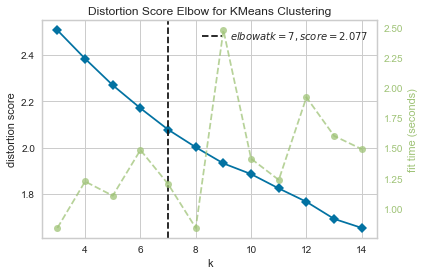

In [115]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(3,15))

visualizer.fit(venues_clustering)
visualizer.poof()

As we see here, there is an optimum value for K = 7, but the elbow is not clear enough, so it is possible that K-Means is not a good fit for this dataset, we need to do some more preprocessing and finally, clustering is not possible. Anyway, let's try with 7 clusters:

In [116]:
# Best K parameter
k_clusters = 7

# Run K-Means clustering algorithm
model = KMeans(n_clusters=k_clusters, random_state=0).fit(venues_clustering)

# Check cluster labels generated for each row in the dataframe
model.labels_[0:10] 

array([6, 2, 5, 1, 3, 3, 3, 1, 5, 1])

Now we have the clusters, we can add them as a new column to the dataframe we had before:

In [125]:
# Add clustering labels
venues_sorted.insert(0, 'Cluster Labels', model.labels_)

venues_merged = cities

# Merge venues_grouped with the DF with the Postal Codes selected
# to add latitude/longitude for each neighborhood group
venues_merged = venues_merged.join(venues_sorted.set_index('City Name'), on='City')

venues_merged.head()

,City,Country,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Hong Kong,22.350627,114.184916,5,Hotel,Park,Japanese Restaurant,Dumpling Restaurant,Dessert Shop,Dim Sum Restaurant,Steakhouse,Electronics Store,Coffee Shop,Art Gallery
1,Bangkok,Thailand,13.753893,100.816080,1,Coffee Shop,Thai Restaurant,Shopping Mall,Noodle House,Asian Restaurant,Dessert Shop,Chinese Restaurant,Japanese Restaurant,Supermarket,Spa
2,London,United Kingdom,51.507322,-0.127647,5,Hotel,Park,Cocktail Bar,Art Museum,Theater,Steakhouse,Department Store,Bookstore,Garden,Pizza Place
3,Singapore,Singapore,1.340863,103.830392,5,Hotel,Park,Shopping Mall,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Dessert Shop,Performing Arts Venue,Sushi Restaurant,Botanical Garden
4,Macau,Macau,22.195629,113.548785,5,Hotel,Café,Chinese Restaurant,Portuguese Restaurant,Coffee Shop,Resort,Cantonese Restaurant,Bakery,Church,Dessert Shop


And lastly, we can visualize the resulting clusters:

In [127]:
# Create a Folium map
map_clusters = folium.Map(location=[0, 0], zoom_start=1)

# Set the color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['City'], venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Section 6: Analyzing the resultant clusters

As the _elbow method_ graphic showed, it is pretty hard to define how many clusters the model should use, as the elbow was not clear enough, and therefore determine the exact caracteristics of each cluster may be a little fuzzy. Anyway, we will try to determine them.

#### Cluster 1:

In [129]:
venues_merged.loc[venues_merged['Cluster Labels'] == 0, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Rome,Italy,Ice Cream Shop,Historic Site,Plaza,Sandwich Place,Monument / Landmark,Italian Restaurant,Church,Fountain,Hotel,Scenic Lookout
25,Milan,Italy,Hotel,Boutique,Italian Restaurant,Plaza,Ice Cream Shop,Pizza Place,Monument / Landmark,Bakery,Coffee Shop,Cocktail Bar
41,Venice,Italy,Italian Restaurant,Hotel,Ice Cream Shop,Plaza,Wine Bar,Church,Museum,Scenic Lookout,Art Gallery,Bakery
47,Florence,Italy,Hotel,Italian Restaurant,Ice Cream Shop,Plaza,Sandwich Place,Art Museum,Museum,Church,Art Gallery,Scenic Lookout


**Main characteristics:**  
This cluster holds uniquely Italy cities and we can observe that the most common venues are Hotels, Plazas and traditional food and ice cream. It is well known that Italy's pastas and gelato are very popular.
Those cities are also places to see monuments, museums and art galleries, which must be very attended.

#### Cluster 2:

In [131]:
venues_merged.loc[venues_merged['Cluster Labels'] == 1, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bangkok,Thailand,Coffee Shop,Thai Restaurant,Shopping Mall,Noodle House,Asian Restaurant,Dessert Shop,Chinese Restaurant,Japanese Restaurant,Supermarket,Spa
6,Paris,France,Plaza,Hotel,Cocktail Bar,Italian Restaurant,French Restaurant,Wine Bar,Art Museum,Bookstore,Seafood Restaurant,Historic Site
7,New York City,United States,Park,Ice Cream Shop,Scenic Lookout,Bookstore,Italian Restaurant,Cycle Studio,Pier,Mediterranean Restaurant,Gym,Furniture / Home Store
12,Tokyo,Japan,BBQ Joint,Hotel,Chinese Restaurant,Art Museum,Garden,Coffee Shop,Tonkatsu Restaurant,Wagashi Place,Kaiseki Restaurant,History Museum
19,Prague,Czech Republic,Café,Park,Ice Cream Shop,Hotel,Cocktail Bar,Coffee Shop,Scenic Lookout,Garden,Yoga Studio,Italian Restaurant
20,Miami,United States,Hotel,Beach,Park,Mexican Restaurant,Seafood Restaurant,Bakery,Peruvian Restaurant,Coffee Shop,Neighborhood,Gym / Fitness Center
21,Seoul,South Korea,Park,Coffee Shop,Hotel,Historic Site,BBQ Joint,Korean Restaurant,Fried Chicken Joint,Palace,Art Museum,Trail
26,Cancún,Mexico,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Sushi Restaurant,Taco Place,Food Truck,Beach,Coffee Shop,Restaurant,Resort
28,Las Vegas,United States,Casino,Theater,Hotel,American Restaurant,Spa,Mexican Restaurant,Steakhouse,Burger Joint,Nightclub,Boutique
30,Antalya,Turkey,Coffee Shop,Park,Seafood Restaurant,Bar,Gym / Fitness Center,Café,Historic Site,Bookstore,Restaurant,Trail


**Main characteristics:**  
This cluster seems to be one of the largest, and we can see there are a lot of Coffee Shops, Hotels and a diverse variety of businesses, meaning those cities are mainly metropolis or capitals (such as Washington, BS AS, Lima, Mexico DF, Moscu, etc.) or very fluent finantial areas with a lot of movement all along the day.

#### Cluster 3:

In [132]:
venues_merged.loc[venues_merged['Cluster Labels'] == 2, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Agra,India,Hotel,Indian Restaurant,Historic Site,Multicuisine Indian Restaurant,Fast Food Restaurant,Coffee Shop,Pizza Place,Café,Resort,Bed & Breakfast
44,Jaipur,India,Hotel,Indian Restaurant,Historic Site,Café,Bakery,Shopping Mall,Tea Room,Palace,Hostel,Ice Cream Shop
75,Marrakesh,Morocco,Moroccan Restaurant,Hotel,Café,Nightclub,Historic Site,Bed & Breakfast,French Restaurant,Lounge,Resort,Restaurant
89,Siem Reap,Cambodia,Hotel,Historic Site,Cambodian Restaurant,Resort,Café,Hostel,Restaurant,Bar,Cocktail Bar,French Restaurant


**Main characteristics:**  
This cluster with four cities hold many Hotels and Historic Sites, such as traditional food restaurants. This group of cities may be very rich in history and traditions, and such is the case of India.

#### Cluster 4:

In [133]:
venues_merged.loc[venues_merged['Cluster Labels'] == 3, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Delhi,India,Indian Restaurant,Hotel,Café,Restaurant,South Indian Restaurant,Monument / Landmark,Italian Restaurant,Art Gallery,Bar,Lounge
16,Mumbai,India,Indian Restaurant,Café,Hotel,Scenic Lookout,Ice Cream Shop,Bar,Coffee Shop,Lounge,Seafood Restaurant,Chinese Restaurant
18,Istanbul,Turkey,Hotel,Soccer Stadium,Historic Site,Dance Studio,Concert Hall,Café,Mosque,History Museum,Sporting Goods Shop,Park
36,Madrid,Spain,Hotel,Plaza,Restaurant,Spanish Restaurant,Ice Cream Shop,Hostel,Café,Tapas Restaurant,Monument / Landmark,Art Gallery
43,Chennai,India,Indian Restaurant,Hotel,Café,Beach,Italian Restaurant,Multiplex,Restaurant,Sandwich Place,Vegetarian / Vegan Restaurant,Men's Store
45,Athens,Greece,Café,Historic Site,Bar,Coffee Shop,Dessert Shop,Souvlaki Shop,Whisky Bar,History Museum,Hotel,Meze Restaurant
46,Dublin,Ireland,Café,Coffee Shop,Pub,Restaurant,Park,Cocktail Bar,Burger Joint,Italian Restaurant,Hotel,Bookstore
59,Munich,Germany,Café,Ice Cream Shop,Hotel,Plaza,Cocktail Bar,German Restaurant,Coffee Shop,Department Store,Beer Garden,Church
60,Lisbon,Portugal,Portuguese Restaurant,Plaza,Hotel,Scenic Lookout,Café,Garden,Restaurant,Ice Cream Shop,Hostel,Wine Bar
62,Heraklion,Greece,Café,Bar,Greek Restaurant,Cocktail Bar,Hotel,Coffee Shop,Dessert Shop,Bakery,Plaza,Cretan Restaurant


**Main characteristics:**  
This cluster only has a lot of cities in it, and seems to be mainly a urban area but with a mix of finantial areas with a lot of hotels and restaurants. Seems to be that although these cities are not capitals, they are important urban centres with a lot of shops and businesses to discover.

#### Cluster 5:

In [134]:
venues_merged.loc[venues_merged['Cluster Labels'] == 4, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Dubai,United Arab Emirates,Resort,Hotel,Beach,Lounge,Coffee Shop,Theme Park Ride / Attraction,Shopping Mall,Restaurant,American Restaurant,Multiplex
10,Phuket,Thailand,Resort,Hotel,Thai Restaurant,Italian Restaurant,Café,Restaurant,Spa,Bar,Dessert Shop,Coffee Shop
23,Pattaya,Thailand,Hotel,Resort,Restaurant,Massage Studio,Thai Restaurant,Bar,Nightclub,Spa,Noodle House,Supermarket
31,Denpasar,Indonesia,Hotel,Resort,Indonesian Restaurant,Café,Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Asian Restaurant,Cocktail Bar
52,Ha Long,Vietnam,Vietnamese Restaurant,Hotel,Cave,Resort,Bay,Asian Restaurant,Beach,Farm,National Park,Night Market
55,Punta Cana,Dominican Republic,Resort,Beach,Golf Course,Hotel,American Restaurant,Bar,Mediterranean Restaurant,Restaurant,Breakfast Spot,Cocktail Bar


**Main characteristics:**  
This cluster is built with mainly relax and vacation cities, where you can go off of the traffic and loud noises of the urban areas. The most common venue in these cities are Resorts and Hotels, but they have a variety of relaxation businesses.

#### Cluster 6:

In [135]:
venues_merged.loc[venues_merged['Cluster Labels'] == 5, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Hong Kong,Hotel,Park,Japanese Restaurant,Dumpling Restaurant,Dessert Shop,Dim Sum Restaurant,Steakhouse,Electronics Store,Coffee Shop,Art Gallery
2,London,United Kingdom,Hotel,Park,Cocktail Bar,Art Museum,Theater,Steakhouse,Department Store,Bookstore,Garden,Pizza Place
3,Singapore,Singapore,Hotel,Park,Shopping Mall,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Dessert Shop,Performing Arts Venue,Sushi Restaurant,Botanical Garden
4,Macau,Macau,Hotel,Café,Chinese Restaurant,Portuguese Restaurant,Coffee Shop,Resort,Cantonese Restaurant,Bakery,Church,Dessert Shop
8,Shenzhen,China,Hotel,Park,Shopping Mall,Coffee Shop,Café,Electronics Store,Noodle House,Theme Park,Multiplex,Chinese Restaurant
9,Kuala Lumpur,Malaysia,Hotel,Shopping Mall,Café,Japanese Restaurant,Grocery Store,Convenience Store,Ice Cream Shop,Coffee Shop,Malay Restaurant,Hotel Bar
14,Taipei,Taiwan,Hotel,Dessert Shop,Dumpling Restaurant,Café,Bookstore,Bakery,Park,Japanese Restaurant,Taiwanese Restaurant,Noodle House
15,Guangzhou,China,Hotel,Turkish Restaurant,Coffee Shop,Shopping Mall,Park,Cantonese Restaurant,Chinese Restaurant,Snack Place,New American Restaurant,Seafood Restaurant
17,Mecca,Saudi Arabia,Hotel,Coffee Shop,Fast Food Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Sandwich Place,Fried Chicken Joint,Burger Joint,Arepa Restaurant,Historic Site
22,Barcelona,Spain,Hotel,Tapas Restaurant,Cocktail Bar,Plaza,Bookstore,Coffee Shop,Spanish Restaurant,Wine Bar,Ice Cream Shop,Pizza Place


**Main characteristics:**  
This cluster has grouped many cities which may be very busy and crowded. The most common venue are Hotels, followed by a lot of traditional food restaurants. Definitely are cities where you go to relax and taste the food.

#### Cluster 7:

In [136]:
venues_merged.loc[venues_merged['Cluster Labels'] == 6, venues_merged.columns[[0,1] + list(range(5, venues_merged.shape[1]))]]

,City,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Zhuhai,China,Beach,Fish & Chips Shop,Gastropub,Cave,Italian Restaurant,Asian Restaurant,Coffee Shop,Café,Dessert Shop,Fondue Restaurant
95,Abu Dhabi,United Arab Emirates,Beach,Boat or Ferry,Campground,Train Station,Middle Eastern Restaurant,Asian Restaurant,Park,Hotel,Grocery Store,Airport


**Main characteristics:**  
This cluster is built with only two cities, which their most popular venue is the beach. Remember that Abu Dhabi only had 11 observations, so it may not be entirely correct to use this city for the clustering model.

## Final thoughts

We have analyzed deeply the most popular and visited cities all around the world and through the data, we are now able to tell which are great areas for a diverse number of businesses types or activities.

We are also able to tell which cities hold a lot of similarities between them and along with that, it may be a good idea to visit together.

In the future, we may analyze even deeper, by obtaining information about more cities, with more venues and analyzing Top Picks or maybe a specific category of venues.

Thank you for reading.
